In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # showing and rendering figures
# io related
from skimage.io import imread
import os
from glob import glob
import matplotlib.pyplot as plt
# not needed in Kaggle, but required in Jupyter
%matplotlib inline 

In [2]:
import tensorflow as tf

In [20]:
base_bone_dir = os.path.join(r'C:\Users\nshetty\Downloads', 'input', 'rsna-bone-age')
age_df = pd.read_csv(os.path.join(base_bone_dir, 'boneage-training-dataset.csv'))
age_df['path'] = age_df['id'].map(lambda x: os.path.join(base_bone_dir,
                                                         'boneage-training-dataset', 
                                                         'boneage-training-dataset', 
                                                         '{}.png'.format(x)))
age_df['exists'] = age_df['path'].map(os.path.exists)
print(age_df['exists'].sum(), 'images found of', age_df.shape[0], 'total')
age_df['gender'] = age_df['male'].map(lambda x: 'male' if x else 'female')
boneage_mean = age_df['boneage'].mean()
boneage_div = 2*age_df['boneage'].std()
# we don't want normalization for now
boneage_mean = 0
boneage_div = 1.0
age_df['boneage_zscore'] = age_df['boneage'].map(lambda x: (x-boneage_mean)/boneage_div)
age_df.dropna(inplace = True)
age_df.sample(3)


12611 images found of 12611 total


,id,boneage,male,path,exists,gender,boneage_zscore
9527,12174,69,False,C:\Users\nshetty\Downloads\input\rsna-bone-age...,True,female,69.0
3572,5534,36,True,C:\Users\nshetty\Downloads\input\rsna-bone-age...,True,male,36.0
11340,14194,138,True,C:\Users\nshetty\Downloads\input\rsna-bone-age...,True,male,138.0


In [22]:
from sklearn.model_selection import train_test_split
raw_train_df, valid_df = train_test_split(age_df, 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = age_df['gender'])
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0])

train 9458 validation 3153


New Data Size: 10000 Old Size: 9458


C:\ProgramData\Anaconda3\envs\tensorflow_env\lib\site-packages\numpy\lib\histograms.py:708: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  a, weights = _ravel_and_check_weights(a, weights)


TypeError: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

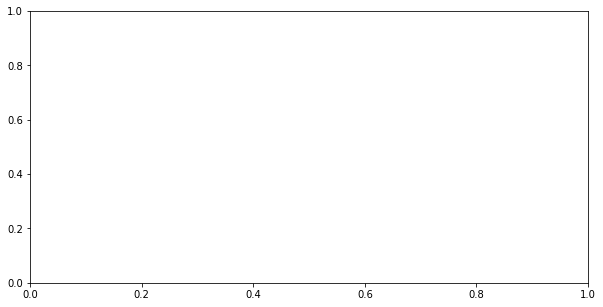

In [23]:
train_df = raw_train_df.groupby(['male']).apply(lambda x: x.sample(5000, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])
train_df['male'].hist(figsize = (10, 5))

In [3]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
IMG_SIZE = (384, 384) # slightly smaller than vgg16 normally expects
core_idg = ImageDataGenerator(samplewise_center=False, 
                              samplewise_std_normalization=False, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.15, 
                              width_shift_range = 0.15, 
                              rotation_range = 5, 
                              shear_range = 0.01,
                              fill_mode = 'nearest',
                              zoom_range=0.25,
                             preprocessing_function = preprocess_input)

Using TensorFlow backend.


In [18]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [24]:
train_gen = flow_from_dataframe(core_idg, train_df, 
                             path_col = 'path',
                            y_col = 'boneage_zscore', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 8)

valid_gen = flow_from_dataframe(core_idg, valid_df, 
                             path_col = 'path',
                            y_col = 'boneage_zscore', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 256) # we can use much larger batches for evaluation
# used a fixed dataset for evaluating the algorithm
test_X, test_Y = next(flow_from_dataframe(core_idg, 
                               valid_df, 
                             path_col = 'path',
                            y_col = 'boneage_zscore', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 1024)) # one big batch

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 10000 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 3153 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 3153 images


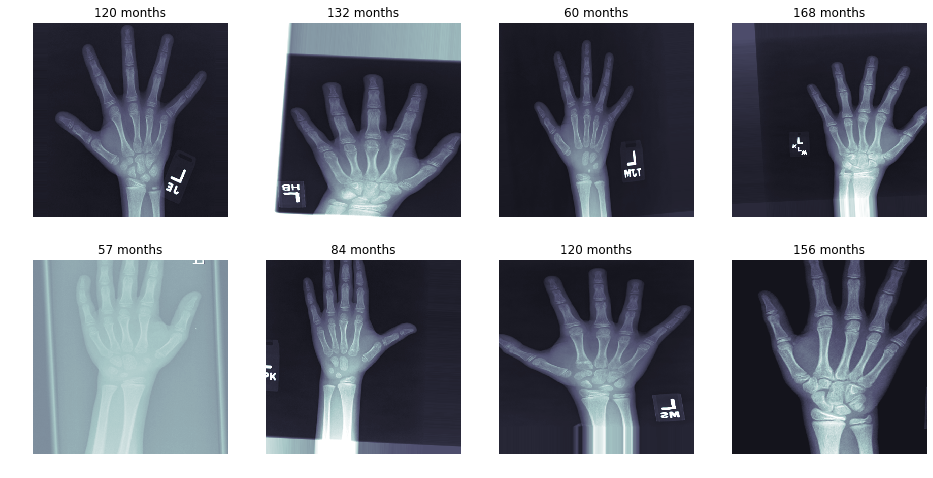

In [25]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -127, vmax = 127)
    c_ax.set_title('%2.0f months' % (c_y*boneage_div+boneage_mean))
    c_ax.axis('off')

# Defining Convolutional Neural Network Architecture

In [4]:
from keras import metrics

Inception V3

In [79]:
from keras.applications.inception_v3 import InceptionV3
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
base_iv3_model = InceptionV3(input_shape =  t_x.shape[1:], include_top = False, weights = 'imagenet')
base_iv3_model.trainable = False
bone_age_model = Sequential()
bone_age_model.add(base_iv3_model)
bone_age_model.add(GlobalAveragePooling2D())
bone_age_model.add(Dropout(0.5))
bone_age_model.add(Dense(1024, activation = 'tanh'))
bone_age_model.add(Dropout(0.25))
bone_age_model.add(Dense(1, activation = 'linear')) # linear is what 16bit did
from keras.metrics import mean_absolute_error
def mae_months(in_gt, in_pred):
    return mean_absolute_error(boneage_div*in_gt, boneage_div*in_pred)

bone_age_model.compile(optimizer = 'adam', loss = 'mse',
                           metrics = ['mae'])

bone_age_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_9 ( (None, 2048)              0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_14 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 1025      
Total params: 23,901,985
Trainable params: 2,099,201
Non-trainable params: 21,802,784
________________________________________________________

VGG16

In [26]:
from keras.applications.vgg16 import VGG16
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from keras.models import Model
in_lay = Input(t_x.shape[1:])
base_pretrained_model = VGG16(input_shape =  t_x.shape[1:], include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False
pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]
pt_features = base_pretrained_model(in_lay)
from keras.layers import BatchNormalization
bn_features = BatchNormalization()(pt_features)

# here we do an attention mechanism to turn pixels in the GAP on an off

attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(bn_features)
attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = LocallyConnected2D(1, 
                                kernel_size = (1,1), 
                                padding = 'valid', 
                                activation = 'sigmoid')(attn_layer)
# fan it out to all of the channels
up_c2_w = np.ones((1, 1, 1, pt_depth))
up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', 
               activation = 'linear', use_bias = False, weights = [up_c2_w])
up_c2.trainable = False
attn_layer = up_c2(attn_layer)

mask_features = multiply([attn_layer, bn_features])
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)
# to account for missing values from the attention model
gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
gap_dr = Dropout(0.5)(gap)
dr_steps = Dropout(0.25)(Dense(1024, activation = 'elu')(gap_dr))
out_layer = Dense(1, activation = 'linear')(dr_steps) # linear is what 16bit did
bone_age_model = Model(inputs = [in_lay], outputs = [out_layer])
from keras.metrics import mean_absolute_error
def mae_months(in_gt, in_pred):
    return mean_absolute_error(boneage_div*in_gt, boneage_div*in_pred)

bone_age_model.compile(optimizer = 'adam', loss = 'mse',
                           metrics = ['mae'])

bone_age_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 384, 384, 3)  0                                            
__________________________________________________________________________________________________
vgg16 (Model)                   (None, 12, 12, 512)  14714688    input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 12, 12, 512)  2048        vgg16[1][0]                      
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 12, 12, 64)   32832       batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

# Training

In [33]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('bone_age')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

C:\ProgramData\Anaconda3\envs\tensorflow_env\lib\site-packages\keras\callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [34]:
bone_age_model.fit_generator(train_gen, 
                                  steps_per_epoch=313,
                                  validation_data = (test_X, test_Y), 
                                  epochs = 15, 
                                  callbacks = callbacks_list)

Epoch 1/15
313/313 [==============================] - 4409s 14s/step - loss: 3640.6114 - mean_absolute_error: 43.1491 - val_loss: 753.2047 - val_mean_absolute_error: 22.3485

Epoch 00001: val_loss improved from inf to 753.20466, saving model to bone_age_weights.best.hdf5
Epoch 2/15
313/313 [==============================] - 4420s 14s/step - loss: 876.1400 - mean_absolute_error: 23.5818 - val_loss: 548.0964 - val_mean_absolute_error: 19.0921

Epoch 00002: val_loss improved from 753.20466 to 548.09640, saving model to bone_age_weights.best.hdf5
Epoch 3/15
313/313 [==============================] - 4411s 14s/step - loss: 746.9784 - mean_absolute_error: 21.8650 - val_loss: 520.7791 - val_mean_absolute_error: 18.4203

Epoch 00003: val_loss improved from 548.09640 to 520.77908, saving model to bone_age_weights.best.hdf5
Epoch 4/15
313/313 [==============================] - 4434s 14s/step - loss: 656.5843 - mean_absolute_error: 20.3983 - val_loss: 490.5586 - val_mean_absolute_error: 17.8506



# Predicting Test Set

In [6]:
#import cv2
import os

In [7]:
from keras.models import load_model

In [8]:
import h5py

In [28]:
bone_age_model.load_weights('general_weights.h5')

In [29]:
bone_age_model.compile(optimizer = 'adam', loss = 'mse',
                           metrics = ['mae'])

In [93]:
#img = cv2.imread(r':\Users\nshetty\Downloads\input\rsna-bone-age\boneage-test-dataset.zip\boneage-test-dataset\4360.png')

In [18]:
#img = cv2.resize(img,(224,224))
#img = np.reshape(img,[1,224,224,3])

In [11]:
from keras.preprocessing import image
import numpy as np

In [31]:
folder_path = 'C:/Users/nshetty/Downloads/input/rsna-bone-age/boneage-test-dataset/boneage-test-dataset'


In [12]:
from keras.preprocessing.image import img_to_array, array_to_img

In [106]:
images = []
for img in os.listdir(folder_path):
    img = image.load_img(r'C:\Users\nshetty\Downloads\input\rsna-bone-age\boneage-test-dataset\boneage-test-dataset\4360.png', target_size=(384, 384))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    images.append(img)

In [50]:

list=[]
flag=0
#Path0="D:\\download dump for Deep learnng\\dataset\\kaggle general competition\\test"
folder_path = 'C:/Users/nshetty/Downloads/input/rsna-bone-age/boneage-test-dataset/boneage-test-dataset'
list=os.listdir(folder_path)
pred0=[0]*len(list)
pred1=[0]*len(list)
for x in list:
    img_path=folder_path+'\\'+ x 
    print() # leave an empty line before each image
    print( img_path )
    img = image.load_img(img_path, target_size=(384, 384))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
   
    print( x ) # let's see if the values make sense
    preds = bone_age_model.predict(x)
    print( preds ) # see if the error is already present here
    


C:/Users/nshetty/Downloads/input/rsna-bone-age/boneage-test-dataset/boneage-test-dataset\4360.png
[[[[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [ 59.  59.  59.]
   [ 85.  85.  85.]
   [108. 108. 108.]]

  [[ 76.  76.  76.]
   [ 72.  72.  72.]
   [ 83.  83.  83.]
   ...
   [ 60.  60.  60.]
   [ 66.  66.  66.]
   [103. 103. 103.]]

  [[ 56.  56.  56.]
   [ 49.  49.  49.]
   [ 44.  44.  44.]
   ...
   [ 59.  59.  59.]
   [ 71.  71.  71.]
   [109. 109. 109.]]

  ...

  [[133. 133. 133.]
   [ 65.  65.  65.]
   [ 47.  47.  47.]
   ...
   [ 49.  49.  49.]
   [ 52.  52.  52.]
   [ 59.  59.  59.]]

  [[129. 129. 129.]
   [ 61.  61.  61.]
   [ 52.  52.  52.]
   ...
   [ 52.  52.  52.]
   [ 54.  54.  54.]
   [ 50.  50.  50.]]

  [[144. 144. 144.]
   [ 68.  68.  68.]
   [ 49.  49.  49.]
   ...
   [ 62.  62.  62.]
   [ 62.  62.  62.]
   [ 67.  67.  67.]]]]
[[150.574]]

C:/Users/nshetty/Downloads/input/rsna-bone-age/boneage-test-dataset/boneage-test-dataset\4361.png
[[[[73. 

[[156.69812]]

C:/Users/nshetty/Downloads/input/rsna-bone-age/boneage-test-dataset/boneage-test-dataset\4371.png
[[[[29. 29. 29.]
   [29. 29. 29.]
   [29. 29. 29.]
   ...
   [12. 12. 12.]
   [20. 20. 20.]
   [33. 33. 33.]]

  [[28. 28. 28.]
   [28. 28. 28.]
   [29. 29. 29.]
   ...
   [15. 15. 15.]
   [26. 26. 26.]
   [36. 36. 36.]]

  [[28. 28. 28.]
   [31. 31. 31.]
   [28. 28. 28.]
   ...
   [15. 15. 15.]
   [29. 29. 29.]
   [35. 35. 35.]]

  ...

  [[30. 30. 30.]
   [29. 29. 29.]
   [29. 29. 29.]
   ...
   [29. 29. 29.]
   [28. 28. 28.]
   [30. 30. 30.]]

  [[31. 31. 31.]
   [30. 30. 30.]
   [29. 29. 29.]
   ...
   [29. 29. 29.]
   [31. 31. 31.]
   [29. 29. 29.]]

  [[30. 30. 30.]
   [30. 30. 30.]
   [29. 29. 29.]
   ...
   [29. 29. 29.]
   [29. 29. 29.]
   [29. 29. 29.]]]]
[[95.28003]]

C:/Users/nshetty/Downloads/input/rsna-bone-age/boneage-test-dataset/boneage-test-dataset\4372.png
[[[[ 86.  86.  86.]
   [ 86.  86.  86.]
   [ 89.  89.  89.]
   ...
   [ 63.  63.  63.]
   [ 86.  86. 

[[162.7665]]

C:/Users/nshetty/Downloads/input/rsna-bone-age/boneage-test-dataset/boneage-test-dataset\4381.png
[[[[56. 56. 56.]
   [57. 57. 57.]
   [56. 56. 56.]
   ...
   [57. 57. 57.]
   [57. 57. 57.]
   [57. 57. 57.]]

  [[56. 56. 56.]
   [55. 55. 55.]
   [56. 56. 56.]
   ...
   [56. 56. 56.]
   [57. 57. 57.]
   [57. 57. 57.]]

  [[56. 56. 56.]
   [55. 55. 55.]
   [56. 56. 56.]
   ...
   [56. 56. 56.]
   [57. 57. 57.]
   [56. 56. 56.]]

  ...

  [[56. 56. 56.]
   [56. 56. 56.]
   [56. 56. 56.]
   ...
   [54. 54. 54.]
   [54. 54. 54.]
   [55. 55. 55.]]

  [[55. 55. 55.]
   [55. 55. 55.]
   [56. 56. 56.]
   ...
   [53. 53. 53.]
   [55. 55. 55.]
   [54. 54. 54.]]

  [[55. 55. 55.]
   [56. 56. 56.]
   [56. 56. 56.]
   ...
   [53. 53. 53.]
   [53. 53. 53.]
   [54. 54. 54.]]]]
[[67.4106]]

C:/Users/nshetty/Downloads/input/rsna-bone-age/boneage-test-dataset/boneage-test-dataset\4382.png
[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 

[[123.26203]]

C:/Users/nshetty/Downloads/input/rsna-bone-age/boneage-test-dataset/boneage-test-dataset\4392.png
[[[[255. 255. 255.]
   [122. 122. 122.]
   [ 69.  69.  69.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  [[255. 255. 255.]
   [126. 126. 126.]
   [ 52.  52.  52.]
   ...
   [ 63.  63.  63.]
   [ 83.  83.  83.]
   [126. 126. 126.]]

  [[255. 255. 255.]
   [144. 144. 144.]
   [ 55.  55.  55.]
   ...
   [ 41.  41.  41.]
   [ 42.  42.  42.]
   [ 40.  40.  40.]]

  ...

  [[ 51.  51.  51.]
   [ 50.  50.  50.]
   [ 49.  49.  49.]
   ...
   [ 53.  53.  53.]
   [ 80.  80.  80.]
   [118. 118. 118.]]

  [[ 53.  53.  53.]
   [ 46.  46.  46.]
   [ 50.  50.  50.]
   ...
   [ 54.  54.  54.]
   [ 76.  76.  76.]
   [124. 124. 124.]]

  [[ 59.  59.  59.]
   [ 64.  64.  64.]
   [ 65.  65.  65.]
   ...
   [ 48.  48.  48.]
   [ 74.  74.  74.]
   [118. 118. 118.]]]]
[[117.04663]]

C:/Users/nshetty/Downloads/input/rsna-bone-age/boneage-test-dataset/boneage-test-dataset\4

[[97.56079]]

C:/Users/nshetty/Downloads/input/rsna-bone-age/boneage-test-dataset/boneage-test-dataset\4403.png
[[[[88. 88. 88.]
   [85. 85. 85.]
   [84. 84. 84.]
   ...
   [88. 88. 88.]
   [82. 82. 82.]
   [90. 90. 90.]]

  [[82. 82. 82.]
   [89. 89. 89.]
   [86. 86. 86.]
   ...
   [87. 87. 87.]
   [87. 87. 87.]
   [88. 88. 88.]]

  [[86. 86. 86.]
   [86. 86. 86.]
   [88. 88. 88.]
   ...
   [86. 86. 86.]
   [86. 86. 86.]
   [86. 86. 86.]]

  ...

  [[89. 89. 89.]
   [89. 89. 89.]
   [89. 89. 89.]
   ...
   [84. 84. 84.]
   [84. 84. 84.]
   [88. 88. 88.]]

  [[90. 90. 90.]
   [88. 88. 88.]
   [87. 87. 87.]
   ...
   [87. 87. 87.]
   [87. 87. 87.]
   [83. 83. 83.]]

  [[87. 87. 87.]
   [88. 88. 88.]
   [83. 83. 83.]
   ...
   [87. 87. 87.]
   [86. 86. 86.]
   [91. 91. 91.]]]]
[[170.32076]]

C:/Users/nshetty/Downloads/input/rsna-bone-age/boneage-test-dataset/boneage-test-dataset\4404.png
[[[[ 80.  80.  80.]
   [ 74.  74.  74.]
   [ 73.  73.  73.]
   ...
   [ 56.  56.  56.]
   [ 61.  61. 

[[126.55101]]

C:/Users/nshetty/Downloads/input/rsna-bone-age/boneage-test-dataset/boneage-test-dataset\4414.png
[[[[104. 104. 104.]
   [101. 101. 101.]
   [104. 104. 104.]
   ...
   [129. 129. 129.]
   [101. 101. 101.]
   [ 97.  97.  97.]]

  [[127. 127. 127.]
   [127. 127. 127.]
   [127. 127. 127.]
   ...
   [ 75.  75.  75.]
   [ 71.  71.  71.]
   [ 86.  86.  86.]]

  [[ 85.  85.  85.]
   [ 76.  76.  76.]
   [ 71.  71.  71.]
   ...
   [ 78.  78.  78.]
   [ 69.  69.  69.]
   [ 92.  92.  92.]]

  ...

  [[151. 151. 151.]
   [ 72.  72.  72.]
   [ 56.  56.  56.]
   ...
   [ 51.  51.  51.]
   [ 53.  53.  53.]
   [ 58.  58.  58.]]

  [[151. 151. 151.]
   [ 72.  72.  72.]
   [ 57.  57.  57.]
   ...
   [ 55.  55.  55.]
   [ 54.  54.  54.]
   [ 59.  59.  59.]]

  [[144. 144. 144.]
   [ 74.  74.  74.]
   [ 51.  51.  51.]
   ...
   [ 66.  66.  66.]
   [ 61.  61.  61.]
   [ 64.  64.  64.]]]]
[[137.18463]]

C:/Users/nshetty/Downloads/input/rsna-bone-age/boneage-test-dataset/boneage-test-dataset\4

[[117.86841]]

C:/Users/nshetty/Downloads/input/rsna-bone-age/boneage-test-dataset/boneage-test-dataset\4424.png
[[[[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  [[ 84.  84.  84.]
   [ 79.  79.  79.]
   [ 65.  65.  65.]
   ...
   [ 69.  69.  69.]
   [122. 122. 122.]
   [122. 122. 122.]]

  [[ 57.  57.  57.]
   [ 47.  47.  47.]
   [ 41.  41.  41.]
   ...
   [ 50.  50.  50.]
   [ 68.  68.  68.]
   [ 86.  86.  86.]]

  ...

  [[ 74.  74.  74.]
   [ 65.  65.  65.]
   [ 54.  54.  54.]
   ...
   [ 50.  50.  50.]
   [ 57.  57.  57.]
   [ 57.  57.  57.]]

  [[ 76.  76.  76.]
   [ 66.  66.  66.]
   [ 56.  56.  56.]
   ...
   [ 54.  54.  54.]
   [ 60.  60.  60.]
   [ 58.  58.  58.]]

  [[ 85.  85.  85.]
   [ 60.  60.  60.]
   [ 57.  57.  57.]
   ...
   [ 56.  56.  56.]
   [ 58.  58.  58.]
   [ 63.  63.  63.]]]]
[[115.342285]]

C:/Users/nshetty/Downloads/input/rsna-bone-age/boneage-test-dataset/boneage-test-dataset\

[[153.95511]]

C:/Users/nshetty/Downloads/input/rsna-bone-age/boneage-test-dataset/boneage-test-dataset\4434.png
[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]]
[[95.3427]]

C:/Users/nshetty/Downloads/input/rsna-bone-age/boneage-test-dataset/boneage-test-dataset\4435.png
[[[[80. 80. 80.]
   [83. 83. 83.]
   [85. 85. 85.]
   ...
   [48. 48. 48.]
   [66. 66. 66.]
   [65. 65. 65.]]

  [[76. 76. 76.]
   [65. 65. 65.]
   [57. 57. 57.]
   ...
   [52. 52. 52.]
   [68. 68. 68.]
   [67.

[[143.71692]]

C:/Users/nshetty/Downloads/input/rsna-bone-age/boneage-test-dataset/boneage-test-dataset\4445.png
[[[[55. 55. 55.]
   [55. 55. 55.]
   [55. 55. 55.]
   ...
   [54. 54. 54.]
   [55. 55. 55.]
   [54. 54. 54.]]

  [[55. 55. 55.]
   [55. 55. 55.]
   [55. 55. 55.]
   ...
   [55. 55. 55.]
   [54. 54. 54.]
   [55. 55. 55.]]

  [[55. 55. 55.]
   [54. 54. 54.]
   [55. 55. 55.]
   ...
   [55. 55. 55.]
   [55. 55. 55.]
   [55. 55. 55.]]

  ...

  [[54. 54. 54.]
   [53. 53. 53.]
   [54. 54. 54.]
   ...
   [54. 54. 54.]
   [55. 55. 55.]
   [54. 54. 54.]]

  [[54. 54. 54.]
   [54. 54. 54.]
   [53. 53. 53.]
   ...
   [54. 54. 54.]
   [56. 56. 56.]
   [55. 55. 55.]]

  [[54. 54. 54.]
   [54. 54. 54.]
   [55. 55. 55.]
   ...
   [55. 55. 55.]
   [53. 53. 53.]
   [55. 55. 55.]]]]
[[165.1321]]

C:/Users/nshetty/Downloads/input/rsna-bone-age/boneage-test-dataset/boneage-test-dataset\4446.png
[[[[62. 62. 62.]
   [62. 62. 62.]
   [62. 62. 62.]
   ...
   [63. 63. 63.]
   [64. 64. 64.]
   [62. 6

[[6.2360964]]

C:/Users/nshetty/Downloads/input/rsna-bone-age/boneage-test-dataset/boneage-test-dataset\4456.png
[[[[ 61.  61.  61.]
   [ 62.  62.  62.]
   [ 63.  63.  63.]
   ...
   [ 85.  85.  85.]
   [ 73.  73.  73.]
   [ 65.  65.  65.]]

  [[ 76.  76.  76.]
   [ 72.  72.  72.]
   [ 73.  73.  73.]
   ...
   [ 75.  75.  75.]
   [ 71.  71.  71.]
   [ 66.  66.  66.]]

  [[ 85.  85.  85.]
   [ 94.  94.  94.]
   [ 92.  92.  92.]
   ...
   [ 75.  75.  75.]
   [ 76.  76.  76.]
   [ 67.  67.  67.]]

  ...

  [[ 68.  68.  68.]
   [ 78.  78.  78.]
   [102. 102. 102.]
   ...
   [ 49.  49.  49.]
   [ 49.  49.  49.]
   [ 52.  52.  52.]]

  [[ 64.  64.  64.]
   [ 78.  78.  78.]
   [105. 105. 105.]
   ...
   [ 50.  50.  50.]
   [ 51.  51.  51.]
   [ 47.  47.  47.]]

  [[ 64.  64.  64.]
   [ 79.  79.  79.]
   [112. 112. 112.]
   ...
   [ 64.  64.  64.]
   [ 65.  65.  65.]
   [ 64.  64.  64.]]]]
[[121.17585]]

C:/Users/nshetty/Downloads/input/rsna-bone-age/boneage-test-dataset/boneage-test-dataset\4

[[138.21648]]

C:/Users/nshetty/Downloads/input/rsna-bone-age/boneage-test-dataset/boneage-test-dataset\4467.png
[[[[100. 100. 100.]
   [100. 100. 100.]
   [ 97.  97.  97.]
   ...
   [ 93.  93.  93.]
   [ 93.  93.  93.]
   [ 95.  95.  95.]]

  [[ 92.  92.  92.]
   [ 97.  97.  97.]
   [ 90.  90.  90.]
   ...
   [ 92.  92.  92.]
   [ 95.  95.  95.]
   [ 98.  98.  98.]]

  [[ 94.  94.  94.]
   [ 98.  98.  98.]
   [101. 101. 101.]
   ...
   [ 98.  98.  98.]
   [ 96.  96.  96.]
   [ 93.  93.  93.]]

  ...

  [[ 96.  96.  96.]
   [ 93.  93.  93.]
   [ 94.  94.  94.]
   ...
   [ 95.  95.  95.]
   [ 96.  96.  96.]
   [ 98.  98.  98.]]

  [[ 93.  93.  93.]
   [ 92.  92.  92.]
   [ 96.  96.  96.]
   ...
   [ 94.  94.  94.]
   [ 93.  93.  93.]
   [ 94.  94.  94.]]

  [[ 94.  94.  94.]
   [ 94.  94.  94.]
   [ 96.  96.  96.]
   ...
   [ 94.  94.  94.]
   [ 99.  99.  99.]
   [100. 100. 100.]]]]
[[71.9885]]

C:/Users/nshetty/Downloads/input/rsna-bone-age/boneage-test-dataset/boneage-test-dataset\446

[[92.9345]]

C:/Users/nshetty/Downloads/input/rsna-bone-age/boneage-test-dataset/boneage-test-dataset\4477.png
[[[[29. 29. 29.]
   [27. 27. 27.]
   [28. 28. 28.]
   ...
   [26. 26. 26.]
   [25. 25. 25.]
   [24. 24. 24.]]

  [[28. 28. 28.]
   [28. 28. 28.]
   [28. 28. 28.]
   ...
   [25. 25. 25.]
   [26. 26. 26.]
   [24. 24. 24.]]

  [[29. 29. 29.]
   [28. 28. 28.]
   [28. 28. 28.]
   ...
   [25. 25. 25.]
   [26. 26. 26.]
   [26. 26. 26.]]

  ...

  [[26. 26. 26.]
   [26. 26. 26.]
   [25. 25. 25.]
   ...
   [24. 24. 24.]
   [24. 24. 24.]
   [24. 24. 24.]]

  [[27. 27. 27.]
   [25. 25. 25.]
   [24. 24. 24.]
   ...
   [24. 24. 24.]
   [26. 26. 26.]
   [26. 26. 26.]]

  [[25. 25. 25.]
   [25. 25. 25.]
   [24. 24. 24.]
   ...
   [25. 25. 25.]
   [26. 26. 26.]
   [25. 25. 25.]]]]
[[140.92775]]

C:/Users/nshetty/Downloads/input/rsna-bone-age/boneage-test-dataset/boneage-test-dataset\4478.png
[[[[103. 103. 103.]
   [ 98.  98.  98.]
   [ 96.  96.  96.]
   ...
   [ 94.  94.  94.]
   [ 95.  95.  

[[111.141106]]

C:/Users/nshetty/Downloads/input/rsna-bone-age/boneage-test-dataset/boneage-test-dataset\4488.png
[[[[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [123. 123. 123.]
   [255. 255. 255.]
   [255. 255. 255.]]

  [[ 68.  68.  68.]
   [ 58.  58.  58.]
   [ 53.  53.  53.]
   ...
   [ 56.  56.  56.]
   [ 67.  67.  67.]
   [105. 105. 105.]]

  [[ 73.  73.  73.]
   [ 59.  59.  59.]
   [ 50.  50.  50.]
   ...
   [ 55.  55.  55.]
   [ 70.  70.  70.]
   [125. 125. 125.]]

  ...

  [[123. 123. 123.]
   [ 69.  69.  69.]
   [ 53.  53.  53.]
   ...
   [ 46.  46.  46.]
   [ 53.  53.  53.]
   [ 63.  63.  63.]]

  [[125. 125. 125.]
   [ 67.  67.  67.]
   [ 54.  54.  54.]
   ...
   [ 48.  48.  48.]
   [ 55.  55.  55.]
   [ 64.  64.  64.]]

  [[123. 123. 123.]
   [ 67.  67.  67.]
   [ 49.  49.  49.]
   ...
   [ 53.  53.  53.]
   [ 58.  58.  58.]
   [ 68.  68.  68.]]]]
[[136.85445]]

C:/Users/nshetty/Downloads/input/rsna-bone-age/boneage-test-dataset/boneage-test-dataset\

[[137.36465]]

C:/Users/nshetty/Downloads/input/rsna-bone-age/boneage-test-dataset/boneage-test-dataset\4498.png
[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]]
[[139.55695]]

C:/Users/nshetty/Downloads/input/rsna-bone-age/boneage-test-dataset/boneage-test-dataset\4499.png
[[[[8. 8. 8.]
   [7. 7. 7.]
   [6. 6. 6.]
   ...
   [7. 7. 7.]
   [7. 7. 7.]
   [8. 8. 8.]]

  [[8. 8. 8.]
   [8. 8. 8.]
   [8. 8. 8.]
   ...
   [5. 5. 5.]
   [6. 6. 6.]
   [5. 5. 5.]]

  [[8. 8. 8.]
   [7. 7

[[102.30433]]

C:/Users/nshetty/Downloads/input/rsna-bone-age/boneage-test-dataset/boneage-test-dataset\4510.png
[[[[41. 41. 41.]
   [41. 41. 41.]
   [41. 41. 41.]
   ...
   [ 0.  0.  0.]
   [ 0.  0.  0.]
   [ 0.  0.  0.]]

  [[41. 41. 41.]
   [41. 41. 41.]
   [41. 41. 41.]
   ...
   [ 0.  0.  0.]
   [ 0.  0.  0.]
   [ 0.  0.  0.]]

  [[41. 41. 41.]
   [41. 41. 41.]
   [41. 41. 41.]
   ...
   [54. 54. 54.]
   [ 0.  0.  0.]
   [ 0.  0.  0.]]

  ...

  [[ 0.  0.  0.]
   [ 0.  0.  0.]
   [39. 39. 39.]
   ...
   [38. 38. 38.]
   [39. 39. 39.]
   [39. 39. 39.]]

  [[ 0.  0.  0.]
   [ 0.  0.  0.]
   [ 0.  0.  0.]
   ...
   [39. 39. 39.]
   [38. 38. 38.]
   [39. 39. 39.]]

  [[ 0.  0.  0.]
   [ 0.  0.  0.]
   [ 0.  0.  0.]
   ...
   [39. 39. 39.]
   [38. 38. 38.]
   [38. 38. 38.]]]]
[[77.39502]]

C:/Users/nshetty/Downloads/input/rsna-bone-age/boneage-test-dataset/boneage-test-dataset\4511.png
[[[[80. 80. 80.]
   [82. 82. 82.]
   [85. 85. 85.]
   ...
   [40. 40. 40.]
   [42. 42. 42.]
   [45. 4

[[150.5353]]

C:/Users/nshetty/Downloads/input/rsna-bone-age/boneage-test-dataset/boneage-test-dataset\4520.png
[[[[ 99.  99.  99.]
   [ 95.  95.  95.]
   [ 98.  98.  98.]
   ...
   [ 96.  96.  96.]
   [ 99.  99.  99.]
   [ 92.  92.  92.]]

  [[ 98.  98.  98.]
   [ 97.  97.  97.]
   [ 90.  90.  90.]
   ...
   [ 92.  92.  92.]
   [ 92.  92.  92.]
   [ 95.  95.  95.]]

  [[ 98.  98.  98.]
   [ 99.  99.  99.]
   [101. 101. 101.]
   ...
   [ 92.  92.  92.]
   [ 94.  94.  94.]
   [ 91.  91.  91.]]

  ...

  [[ 96.  96.  96.]
   [ 92.  92.  92.]
   [ 97.  97.  97.]
   ...
   [202. 202. 202.]
   [233. 233. 233.]
   [255. 255. 255.]]

  [[ 97.  97.  97.]
   [100. 100. 100.]
   [102. 102. 102.]
   ...
   [205. 205. 205.]
   [234. 234. 234.]
   [255. 255. 255.]]

  [[ 99.  99.  99.]
   [ 99.  99.  99.]
   [ 97.  97.  97.]
   ...
   [212. 212. 212.]
   [232. 232. 232.]
   [255. 255. 255.]]]]
[[215.54268]]

C:/Users/nshetty/Downloads/input/rsna-bone-age/boneage-test-dataset/boneage-test-dataset\45

[[181.93918]]

C:/Users/nshetty/Downloads/input/rsna-bone-age/boneage-test-dataset/boneage-test-dataset\4531.png
[[[[6. 6. 6.]
   [7. 7. 7.]
   [5. 5. 5.]
   ...
   [5. 5. 5.]
   [6. 6. 6.]
   [5. 5. 5.]]

  [[5. 5. 5.]
   [5. 5. 5.]
   [6. 6. 6.]
   ...
   [5. 5. 5.]
   [5. 5. 5.]
   [5. 5. 5.]]

  [[6. 6. 6.]
   [5. 5. 5.]
   [6. 6. 6.]
   ...
   [4. 4. 4.]
   [5. 5. 5.]
   [6. 6. 6.]]

  ...

  [[5. 5. 5.]
   [5. 5. 5.]
   [5. 5. 5.]
   ...
   [6. 6. 6.]
   [5. 5. 5.]
   [5. 5. 5.]]

  [[6. 6. 6.]
   [7. 7. 7.]
   [5. 5. 5.]
   ...
   [5. 5. 5.]
   [4. 4. 4.]
   [6. 6. 6.]]

  [[7. 7. 7.]
   [6. 6. 6.]
   [7. 7. 7.]
   ...
   [3. 3. 3.]
   [5. 5. 5.]
   [4. 4. 4.]]]]
[[55.91573]]

C:/Users/nshetty/Downloads/input/rsna-bone-age/boneage-test-dataset/boneage-test-dataset\4532.png
[[[[125. 125. 125.]
   [125. 125. 125.]
   [116. 116. 116.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  [[116. 116. 116.]
   [115. 115. 115.]
   [ 63.  63.  63.]
   ...
   [ 83.  83.

[[114.00737]]

C:/Users/nshetty/Downloads/input/rsna-bone-age/boneage-test-dataset/boneage-test-dataset\4542.png
[[[[63. 63. 63.]
   [63. 63. 63.]
   [63. 63. 63.]
   ...
   [62. 62. 62.]
   [63. 63. 63.]
   [63. 63. 63.]]

  [[62. 62. 62.]
   [63. 63. 63.]
   [63. 63. 63.]
   ...
   [62. 62. 62.]
   [62. 62. 62.]
   [63. 63. 63.]]

  [[62. 62. 62.]
   [63. 63. 63.]
   [63. 63. 63.]
   ...
   [63. 63. 63.]
   [62. 62. 62.]
   [63. 63. 63.]]

  ...

  [[64. 64. 64.]
   [63. 63. 63.]
   [61. 61. 61.]
   ...
   [ 0.  0.  0.]
   [63. 63. 63.]
   [62. 62. 62.]]

  [[61. 61. 61.]
   [63. 63. 63.]
   [61. 61. 61.]
   ...
   [ 0.  0.  0.]
   [62. 62. 62.]
   [62. 62. 62.]]

  [[61. 61. 61.]
   [63. 63. 63.]
   [62. 62. 62.]
   ...
   [62. 62. 62.]
   [61. 61. 61.]
   [61. 61. 61.]]]]
[[147.26265]]

C:/Users/nshetty/Downloads/input/rsna-bone-age/boneage-test-dataset/boneage-test-dataset\4543.png
[[[[63. 63. 63.]
   [63. 63. 63.]
   [63. 63. 63.]
   ...
   [62. 62. 62.]
   [62. 62. 62.]
   [62. 

[[199.25983]]

C:/Users/nshetty/Downloads/input/rsna-bone-age/boneage-test-dataset/boneage-test-dataset\4552.png
[[[[125. 125. 125.]
   [126. 126. 126.]
   [124. 124. 124.]
   ...
   [129. 129. 129.]
   [125. 125. 125.]
   [127. 127. 127.]]

  [[125. 125. 125.]
   [125. 125. 125.]
   [124. 124. 124.]
   ...
   [125. 125. 125.]
   [127. 127. 127.]
   [126. 126. 126.]]

  [[126. 126. 126.]
   [123. 123. 123.]
   [123. 123. 123.]
   ...
   [125. 125. 125.]
   [128. 128. 128.]
   [122. 122. 122.]]

  ...

  [[125. 125. 125.]
   [125. 125. 125.]
   [123. 123. 123.]
   ...
   [126. 126. 126.]
   [123. 123. 123.]
   [124. 124. 124.]]

  [[125. 125. 125.]
   [127. 127. 127.]
   [124. 124. 124.]
   ...
   [123. 123. 123.]
   [124. 124. 124.]
   [125. 125. 125.]]

  [[126. 126. 126.]
   [126. 126. 126.]
   [123. 123. 123.]
   ...
   [123. 123. 123.]
   [125. 125. 125.]
   [126. 126. 126.]]]]
[[109.80242]]

C:/Users/nshetty/Downloads/input/rsna-bone-age/boneage-test-dataset/boneage-test-dataset\4

In [56]:
img = image.load_img(r'C:\Users\nshetty\Downloads\input\rsna-bone-age\boneage-test-dataset\boneage-test-dataset\4386.png', target_size=(384,384))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = bone_age_model.predict(images)

In [57]:
classes

array([[63.90222]], dtype=float32)

In [102]:
x.shape

(1, 384, 384, 3)

In [58]:
test_X.shape

(1024, 384, 384, 3)

# Fitting Validation Set

In [21]:
for attn_layer in bone_age_model.layers:
    c_shape = attn_layer.get_output_shape_at(0)
    if len(c_shape)==4:
        if c_shape[-1]==1:
            print(attn_layer)
            break

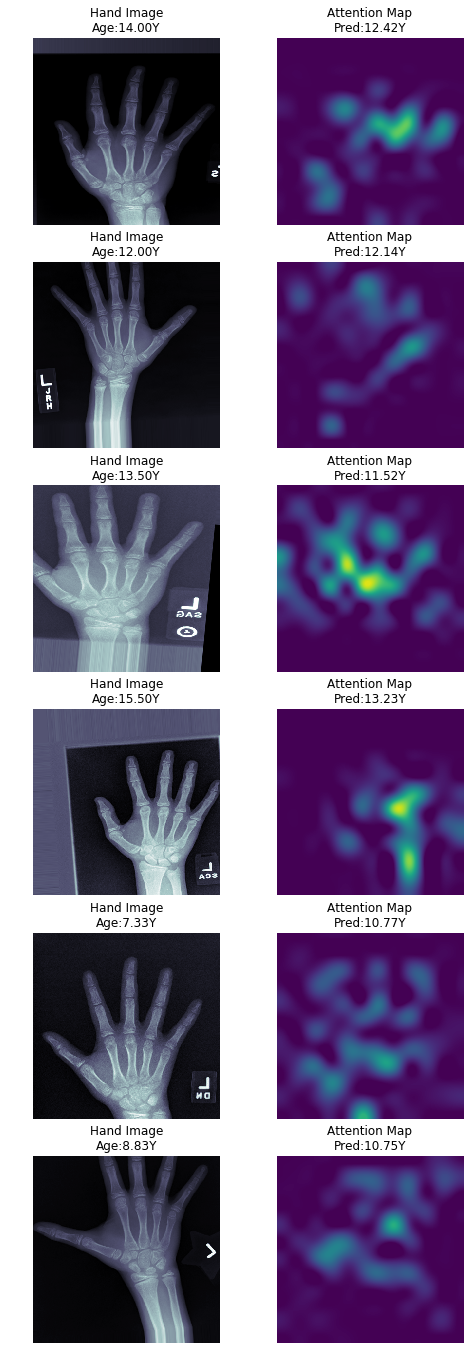

In [22]:
import keras.backend as K
rand_idx = np.random.choice(range(len(test_X)), size = 6)
attn_func = K.function(inputs = [bone_age_model.get_input_at(0), K.learning_phase()],
           outputs = [attn_layer.get_output_at(0)]
          )
fig, m_axs = plt.subplots(len(rand_idx), 2, figsize = (8, 4*len(rand_idx)))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
for c_idx, (img_ax, attn_ax) in zip(rand_idx, m_axs):
    cur_img = test_X[c_idx:(c_idx+1)]
    attn_img = attn_func([cur_img, 0])[0]
    img_ax.imshow(cur_img[0,:,:,0], cmap = 'bone')
    attn_ax.imshow(attn_img[0, :, :, 0], cmap = 'viridis', 
                   vmin = 0, vmax = 1, 
                   interpolation = 'lanczos')
    real_age = boneage_div*test_Y[c_idx]+boneage_mean
    img_ax.set_title('Hand Image\nAge:%2.2fY' % (real_age/12))
    pred_age = boneage_div*bone_age_model.predict(cur_img)+boneage_mean
    attn_ax.set_title('Attention Map\nPred:%2.2fY' % (pred_age/12))
fig.savefig('attention_map.png', dpi = 300)

In [50]:
images.shape

(76800, 384, 3)

In [23]:
pred_Y = boneage_div*bone_age_model.predict(test_X, batch_size = 32, verbose = True)+boneage_mean
test_Y_months = boneage_div*test_Y+boneage_mean

1024/1024 [==============================] - 1407s 1s/step


Text(0, 0.5, 'Predicted Age (Months)')

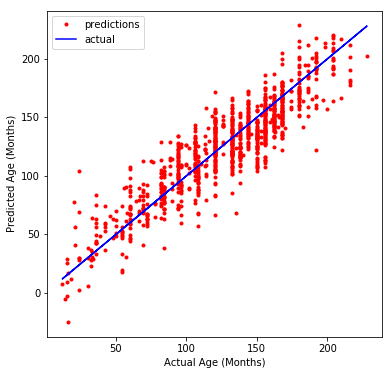

In [24]:
fig, ax1 = plt.subplots(1,1, figsize = (6,6))
ax1.plot(test_Y_months, pred_Y, 'r.', label = 'predictions')
ax1.plot(test_Y_months, test_Y_months, 'b-', label = 'actual')
ax1.legend()
ax1.set_xlabel('Actual Age (Months)')
ax1.set_ylabel('Predicted Age (Months)')

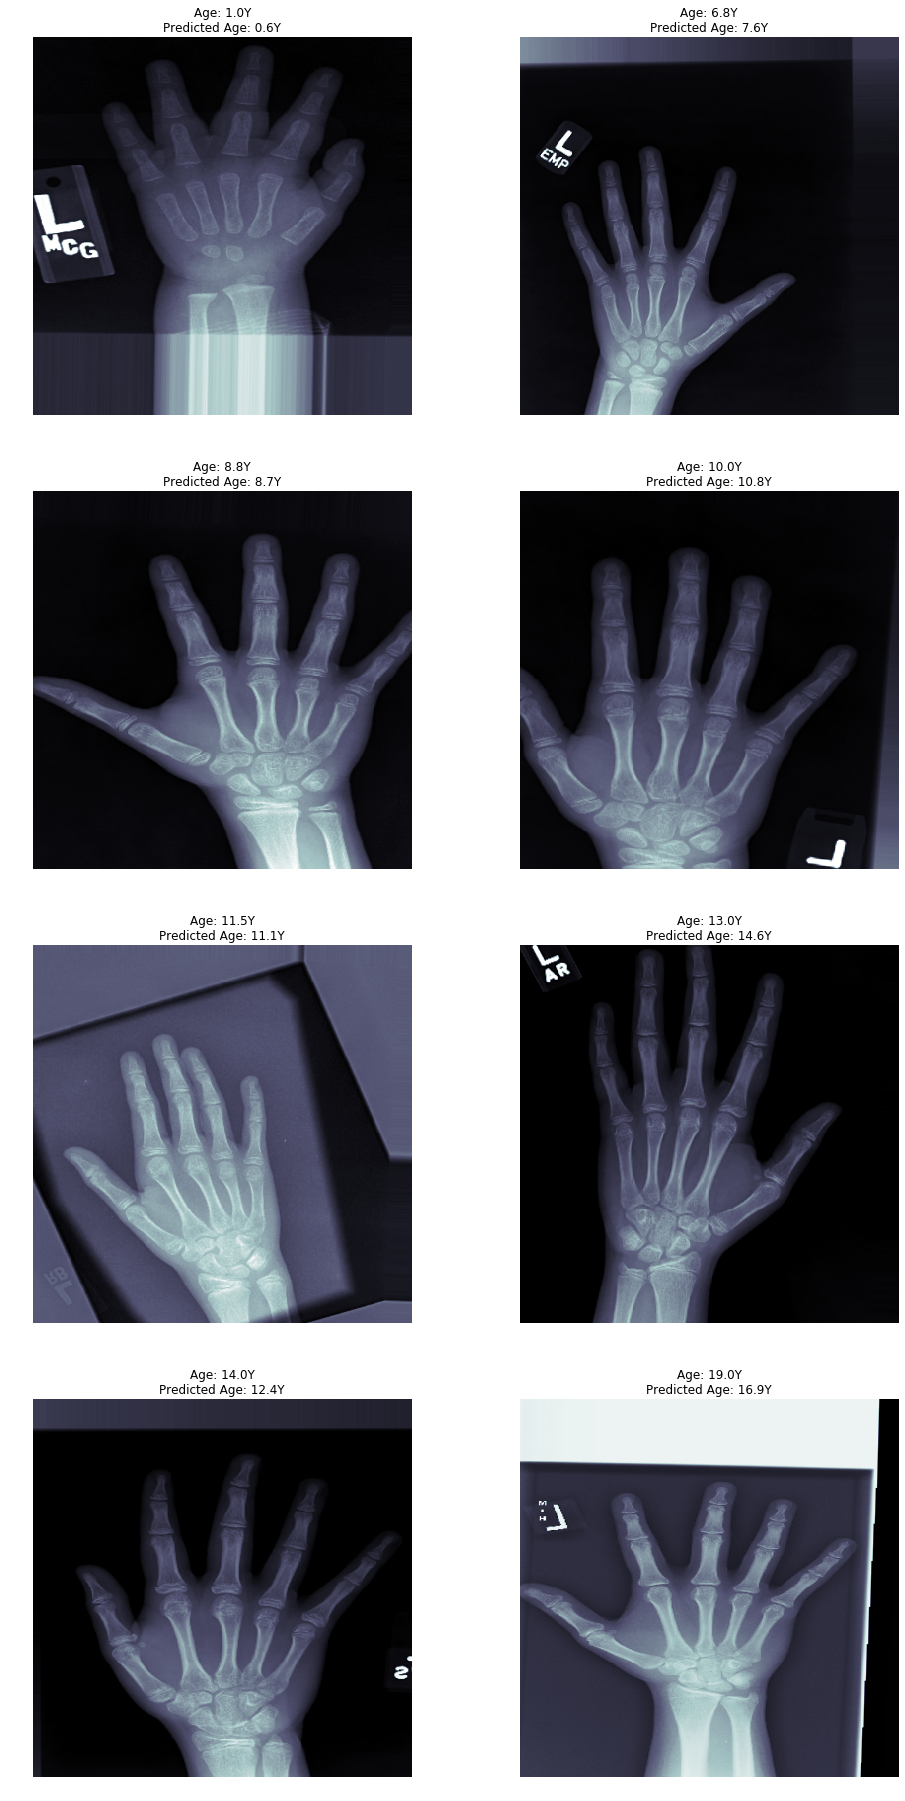

In [25]:
ord_idx = np.argsort(test_Y)
ord_idx = ord_idx[np.linspace(0, len(ord_idx)-1, 8).astype(int)] # take 8 evenly spaced ones
fig, m_axs = plt.subplots(4, 2, figsize = (16, 32))
for (idx, c_ax) in zip(ord_idx, m_axs.flatten()):
    c_ax.imshow(test_X[idx, :,:,0], cmap = 'bone')
    
    c_ax.set_title('Age: %2.1fY\nPredicted Age: %2.1fY' % (test_Y_months[idx]/12.0, 
                                                           pred_Y[idx]/12.0))
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png', dpi = 300)